# IMT 575 C - Group Project - TradeX

## Module: Reddit.py Ver.01

### Durga Prasad Tavva

#### 05/06/2022

#### Load Reddit Scrapper Module

In [1]:
# %load reddit_scraper_module.py
"""This module contains helper functions for the PushShift API object.
   The functions in thiss module help a user taken in a PushShift API
   return object, clean the values, and return a dataframe with the
   cleaned values as well as date, and stock ticker values as separate
   rows.

   Returns:
   [Pandas DataFrame]: DataFrame object cleaned reddit submissions."""
import datetime as dt
import re

class RedditData:
    '''
    This class contains helper functions that parse through a PushShift API object to return a
    cleaned dataframe with separated Date-wise Tags and Comment values.
    '''
    def __init__(self, name):
        self.name = name
    @staticmethod

    def has_numbers(input_string):
        '''
        This function looks at the $Tag and checks if it contains a dollar value or a ticker symbol.
        For eg. is it $9 or $AMC. Returns True if it is a number and false if it is a string.
        '''
        return any(char.isdigit() for char in input_string)

    @staticmethod
    def get_subreddit_column(subreddit, lst_tags):
        '''
        This function takes the channel variable and the dataframe of api results as input
        and adds a column in the same dataframe of the length of the dataframe and populates
        it with the name of the subreddit (channel variable) name.
        '''
        arr_subreddit = []
        size = len(lst_tags)
        arr_subreddit += size * [str(subreddit)]
        return arr_subreddit

    @staticmethod
    def cashtags(submissions):
        '''
        This function takes the api JSON values and the dataframe. It extracts the $Tags from the
        comments and stores them in a separate column, corresponding to the row of the comment.
        It also filters out the $Tags that are empty and those that have a $Numerical value.
        Returns a list of tags and a list of comments.
        '''
        #pylint: disable=too-many-locals
        tag_list = []
        comment_list = []
        date_list = []
        subreddit_list = []
        lst_tag = []
        lst_comments = []
        lst_date = []
        lst_subreddit = []
        for submit in submissions:
            words = submit.title.split()
            cashtags = list(set(filter(lambda word: word.lower().startswith('$'), words)))
            if  len(cashtags) > 0:
                val = RedditData.has_numbers(str(cashtags))
                if  not val:
                    tag_list.append(cashtags)
                    comment_list.append(submit.title)
                    date = dt.datetime.fromtimestamp(submit.created_utc)
                    #pylint: disable=syntax-error
                    date = date.replace(tzinfo=dt.timezone.utc).strftime("%m/%d/%Y %H")
                    date_list.append(date)
                    subreddit_list.append(submit.subreddit)
        length = len(tag_list)
        for i in range(length):
            if len(tag_list[i]) >= 1:
                for j in range(len(tag_list[i])):
                    clean_tag = RedditData.has_special_chars((tag_list[i][j]))
                    lst_tag.append(clean_tag)
                    lst_comments.append(comment_list[i])
                    lst_date.append(date_list[i])
                    lst_subreddit.append(subreddit_list[i])
        return lst_tag, lst_comments, lst_date, lst_subreddit

    @staticmethod
    def add_to_df(tag_values, comment_values, date_values, subreddit_values, df_data):
        '''
        This function takes the list of tags, list of columns, subreddit list and the working
        dataframe as inputs and appends each values to the corresponding rows.
        '''
        length_comment = len(comment_values)
        for i in range(length_comment):
            df_length = len(df_data)
            df_data.loc[df_length] = date_values[i], comment_values[i], tag_values[i], subreddit_values[i]

    @staticmethod
    def has_special_chars(input_string):
        '''
        This function takes a string that is stripped of the $ sign from the ticker and
        returns coded value. Codes:- 1: Valid Ticker (No special characters), -1:
        Trailing Special Character(Requires removal of trailing character) and 0:
        Invalid Ticker (Contains non-trailing special characters).
        '''
        sub_str = input_string[1:]
        dollar_char = input_string[:1]
        bool_result = RedditData.__have_special_chars(sub_str)
        if bool_result:
            sub_str = re.sub(r'\W+', '', sub_str)
        clean_string = dollar_char + sub_str
        return clean_string.upper()
    #pylint: disable=inconsistent-return-statements
    @staticmethod
    def __have_special_chars(sub_string):
        '''
        This is a helper function used inside the has_special_chars() function that takes
        in a string as an input and returns boolean True if the passed string contains a
        special character.
        '''
        regexp = re.compile('[^a-zA-Z]+')
        if regexp.search(sub_string):
            return True


#### Part 1. Import Libraries and initiate the local variables

In [7]:
from psaw import PushshiftAPI
import pandas as pd
from datetime import datetime, timedelta
import reddit_scraper_module as rd
import matplotlib.pyplot as plt
import warnings

redAPI = PushshiftAPI()
filename = 'Reddit_Data.csv'

stocks = ['$FB','$AMZN','$AAPL','$NFLX','$GOOG']
subreddits = ['wallstreetbets','RobinHood','Stocks','investing','StockMarket']
#
#df_main = pd.DataFrame(columns = ['Date','Comment', 'Tags','subreddit'])
#df_main.rea


#### 1.1 Function to identify the Dates for Scrapping Reddit

In [5]:
def returndates(df):
    before = datetime.now()
    after = datetime(2021, 1, 1)
    if df['Date'].count() > 0:
        print('1')
        after =max(pd.to_datetime(df["Date"],format='%m/%d/%Y %H'))
    before = int(before.timestamp())
    after = int(after.timestamp())
    return before, after

#### 1.2 Scrap Reddit Data for identified Subreddits and write data to file

In [8]:
#after = int(datetime(2022, 4, 1).timestamp())
#before = int(datetime(2022, 5, 4).timestamp())
warnings.filterwarnings('ignore')
for subreddit in subreddits:
    print(subreddit)
    df_main = pd.read_csv(filename)
    before, after = returndates(df_main[df_main["Subreddit"] == subreddit])
    
    while before > after:
        df_reddit = pd.DataFrame(columns = df_main.columns) 
        searchposts = list(redAPI.search_submissions(after=after, before=before,
                                    subreddit=subreddit,
                                    filter=['url','author', 'title', 'subreddit'],
                                    limit=10000))
        tag, comment, date,sreddit = rd.RedditData.cashtags(searchposts)
        if len(tag) > 0:
            print(datetime.fromtimestamp(before))
            rd.RedditData.add_to_df(tag, comment, date, sreddit,df_reddit)
            b1  = min(pd.to_datetime(df_reddit["Date"],format='%m/%d/%Y %H'))
            df_reddit = df_reddit[df_reddit["Tags"].isin(stocks)]
            if df_reddit['Date'].count() > 0:
                print(df_reddit['Date'].count())
                df_reddit.to_csv(filename,header=False,index=False,mode='a' )
#            else:
#                b1 = datetime.fromtimestamp(before)-timedelta(days=1)    
        else:
            #b1 = datetime.fromtimestamp(before)-timedelta(days=1)
            b1 = datetime.fromtimestamp(after)
        before = int(b1.timestamp())

wallstreetbets
1


KeyboardInterrupt: 

In [ ]:
#after = datetime(2021, 1, 1)
#after =  int(after.timestamp())
#print(before,after)

### Part 2. Read the data from Reddit_Data.CSV

In [9]:
df_main = pd.read_csv(filename)
df_main["Time"] = pd.to_datetime(df_main["Date"],format='%m/%d/%Y %H')
df_main["Date"] = pd.to_datetime(df_main["Time"].dt.strftime('%m/%d/%Y'))
df_main.head()

,Date,Comment,Tags,Subreddit,Time
0,2022-05-04,$fb calls,$FB,wallstreetbets,2022-05-04 19:00:00
1,2022-05-04,$fb,$FB,wallstreetbets,2022-05-04 19:00:00
2,2022-05-04,$fb?,$FB,wallstreetbets,2022-05-04 19:00:00
3,2022-05-04,Win porn! Thank you $AAPL,$AAPL,wallstreetbets,2022-05-04 13:00:00
4,2022-05-04,"So, I bought a sh*t load of $NFLX the day it w...",$NFLX,wallstreetbets,2022-05-04 07:00:00


#### 2.1 Exploratory Data Analysis

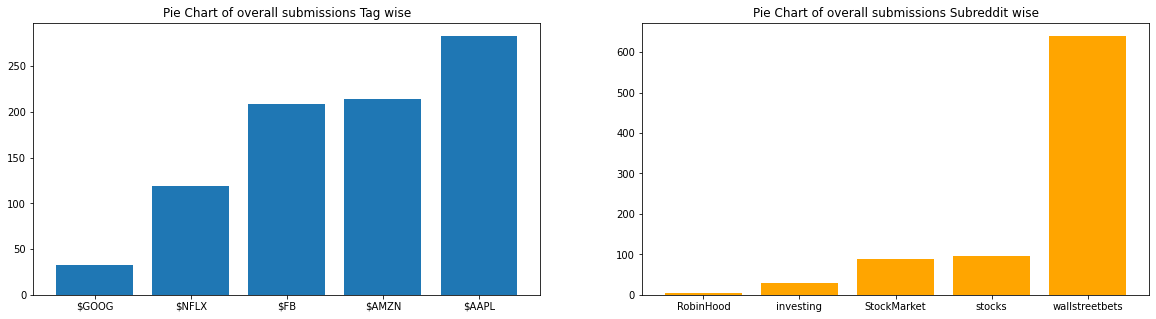

<Figure size 720x720 with 0 Axes>

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,5))
#plt.title('Pie Chart of overall submissions Tag wise')
fig = plt.figure(figsize=(10,10))

dfgroup = df_main.groupby(['Tags'])['Comment'].count().reset_index().sort_values(by="Comment")
#dfgroup = dfgroup
ax1.set_title('Pie Chart of overall submissions Tag wise')
#ax1.pie(dfgroup["Comment"],labels=, autopct='%1.1f%%')
ax1.bar(dfgroup["Tags"],dfgroup["Comment"])

dfgroup = df_main.groupby(['Subreddit'])['Comment'].count().reset_index().sort_values(by="Comment")
ax2.set_title('Pie Chart of overall submissions Subreddit wise')
#ax2.pie(dfgroup["Comment"],labels=dfgroup["Subreddit"], autopct='%1.1f%%')
ax2.bar(dfgroup["Subreddit"],dfgroup["Comment"],color = 'orange')
plt.show()

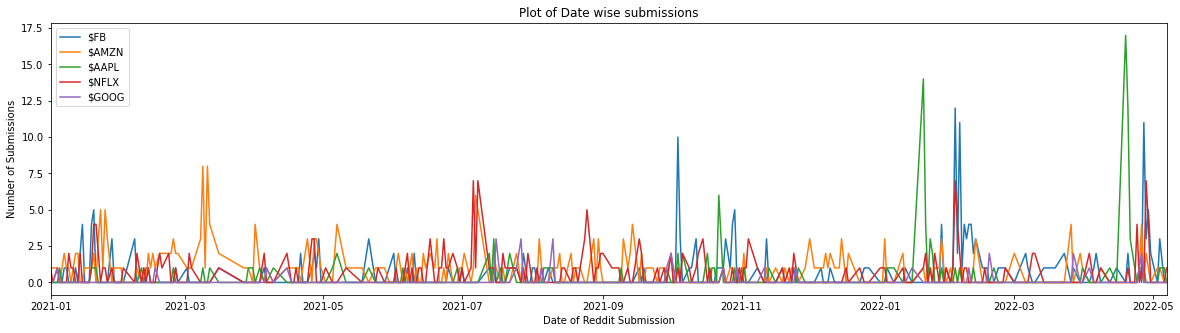

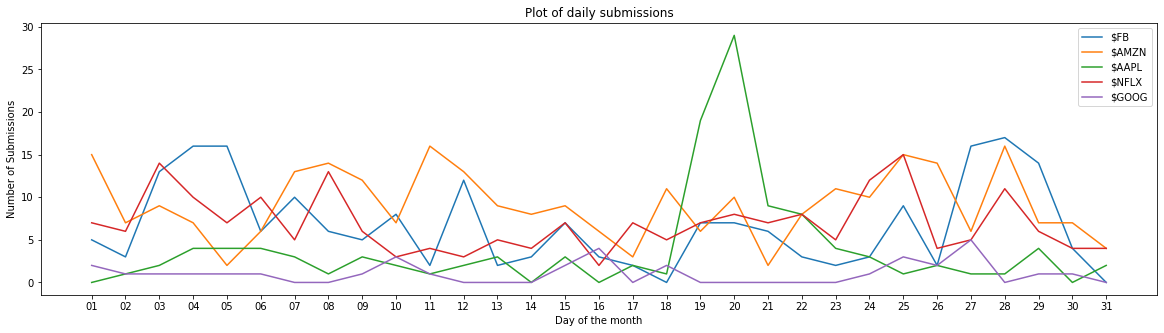

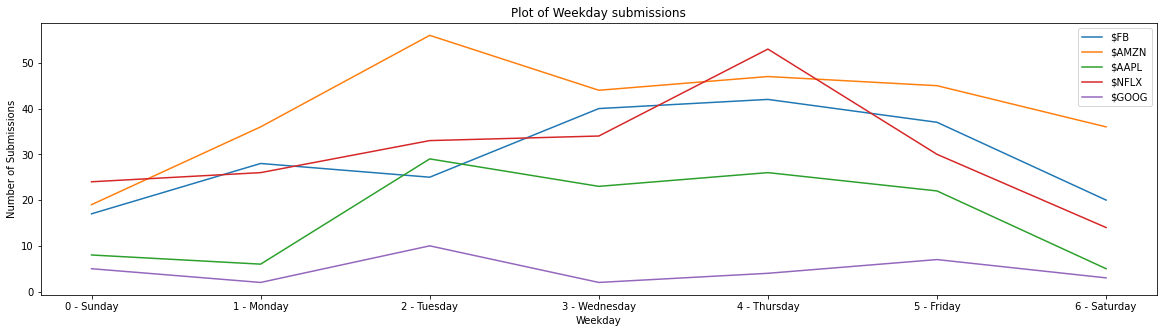

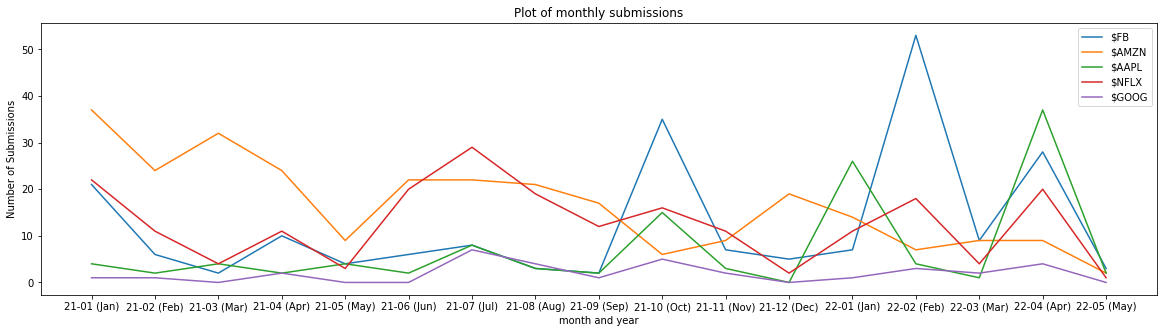

In [13]:
dfgroup = df_main.groupby(['Date','Tags'])['Subreddit'].count().reset_index(name = 'Subreddit')
dfgroup = pd.DataFrame(dfgroup.pivot_table(index='Date',columns='Tags',values='Subreddit')).reset_index().fillna(0)
fig = plt.figure(figsize=(20,5))
plt.xlim(min(dfgroup["Date"]),max(dfgroup["Date"]))
plt.title('Plot of Date wise submissions')
plt.xlabel('Date of Reddit Submission')
plt.ylabel('Number of Submissions')
plt.plot(dfgroup["Date"],dfgroup[df_main["Tags"].unique()])
plt.legend(stocks)
plt.show()

df_main["DayOfMonth"] = df_main["Date"].dt.strftime('%d')
dfgroup = df_main.groupby(['DayOfMonth','Tags'])['Subreddit'].count().reset_index(name = 'Subreddit')
dfgroup = pd.DataFrame(dfgroup.pivot_table(index='DayOfMonth',columns='Tags',values='Subreddit')).reset_index().fillna(0)
fig = plt.figure(figsize=(20,5))
plt.title('Plot of daily submissions')
plt.xlabel('Day of the month')
plt.ylabel('Number of Submissions')
plt.plot(dfgroup["DayOfMonth"],dfgroup[df_main["Tags"].unique()])
plt.legend(stocks)
plt.show()

df_main["Day"] = df_main["Date"].dt.strftime('%w - %A')
dfgroup = df_main.groupby(['Day','Tags'])['Subreddit'].count().reset_index(name = 'Subreddit')
dfgroup = pd.DataFrame(dfgroup.pivot_table(index='Day',columns='Tags',values='Subreddit')).reset_index().fillna(0)
fig = plt.figure(figsize=(20,5))
plt.title('Plot of Weekday submissions')
plt.xlabel('Weekday')
plt.ylabel('Number of Submissions')
plt.plot(dfgroup["Day"],dfgroup[df_main["Tags"].unique()])
plt.legend(stocks)
plt.show()

df_main["month"] = df_main["Date"].dt.strftime('%y-%m (%b)')
dfgroup = df_main.groupby(['month','Tags'])['Subreddit'].count().reset_index(name = 'Subreddit')
dfgroup = pd.DataFrame(dfgroup.pivot_table(index='month',columns='Tags',values='Subreddit')).reset_index().fillna(0)
fig = plt.figure(figsize=(20,5))
plt.title('Plot of monthly submissions')
plt.xlabel('month and year')
plt.ylabel('Number of Submissions')
plt.plot(dfgroup["month"],dfgroup[df_main["Tags"].unique()])
plt.legend(stocks)
plt.show()

In [14]:
df_main

,Date,Comment,Tags,Subreddit,Time,DayOfMonth,Day,month
0,2022-05-04,$fb calls,$FB,wallstreetbets,2022-05-04 19:00:00,04,3 - Wednesday,22-05 (May)
1,2022-05-04,$fb,$FB,wallstreetbets,2022-05-04 19:00:00,04,3 - Wednesday,22-05 (May)
2,2022-05-04,$fb?,$FB,wallstreetbets,2022-05-04 19:00:00,04,3 - Wednesday,22-05 (May)
3,2022-05-04,Win porn! Thank you $AAPL,$AAPL,wallstreetbets,2022-05-04 13:00:00,04,3 - Wednesday,22-05 (May)
4,2022-05-04,"So, I bought a sh*t load of $NFLX the day it w...",$NFLX,wallstreetbets,2022-05-04 07:00:00,04,3 - Wednesday,22-05 (May)
...,...,...,...,...,...,...,...,...
853,2021-02-02,$AMZN Amazing interview of Jeff Bezos before b...,$AMZN,StockMarket,2021-02-02 15:00:00,02,2 - Tuesday,21-02 (Feb)
854,2021-02-01,Does this mean $AAPL is going up?,$AAPL,StockMarket,2021-02-01 16:00:00,01,1 - Monday,21-02 (Feb)
855,2021-01-28,Name me a fundamentally cheaper stock than Fac...,$FB,StockMarket,2021-01-28 13:00:00,28,4 - Thursday,21-01 (Jan)
856,2021-01-12,$AAPL Tim Cook is making a big announcement to...,$AAPL,StockMarket,2021-01-12 20:00:00,12,2 - Tuesday,21-01 (Jan)


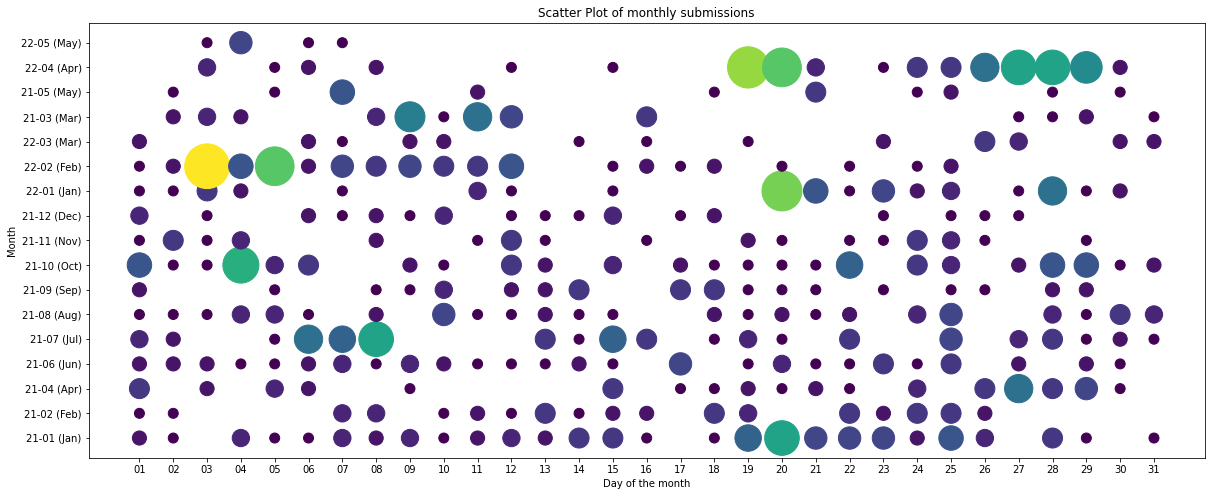

In [15]:
dfgroup = df_main.groupby(['DayOfMonth','month'])['Subreddit'].count().reset_index(name = 'Subreddit')
fig = plt.figure(figsize=(20,8))
plt.title('Scatter Plot of monthly submissions')
plt.xlabel('Day of the month')
plt.ylabel('Month')
plt.scatter(dfgroup["DayOfMonth"],dfgroup["month"],s=dfgroup["Subreddit"]*100,c=dfgroup["Subreddit"])
plt.show()

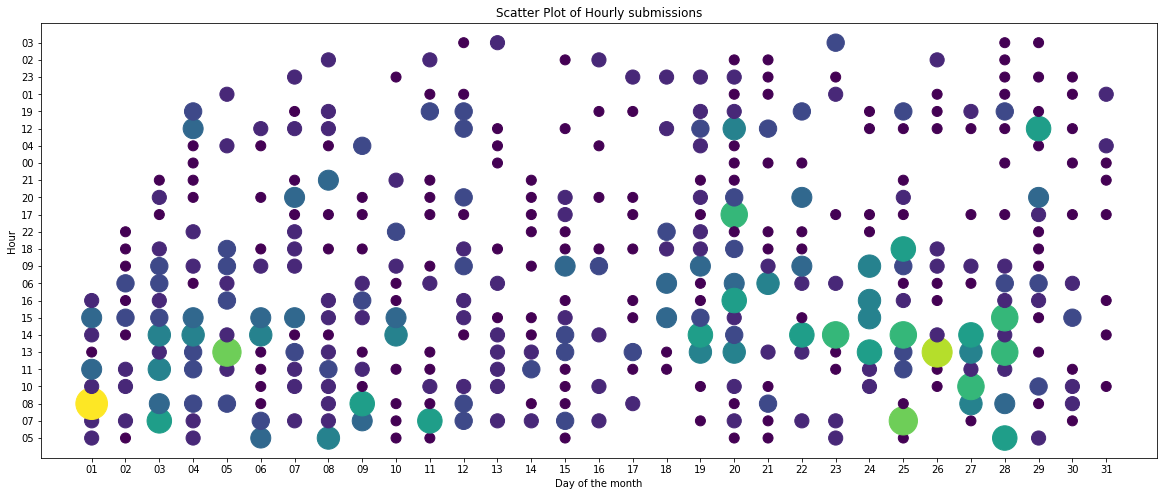

In [16]:
df_main["Hour"] = df_main["Time"].dt.strftime('%H')
dfgroup = df_main.groupby(['DayOfMonth','Hour'])['Subreddit'].count().reset_index(name = 'Subreddit')
fig = plt.figure(figsize=(20,8))
plt.title('Scatter Plot of Hourly submissions')
plt.xlabel('Day of the month')
plt.ylabel('Hour')
plt.scatter(dfgroup["DayOfMonth"],dfgroup["Hour"],s=dfgroup["Subreddit"]*100,c=dfgroup["Subreddit"])
plt.show()

### Part 3. Sentiment Analysis

In [ ]:
# %load vader_working_file.py
"""[This module contains helper functions for generating the vader sentiment scores
    for the reddit api submissions.]

Returns:
    [DataFrame]: [A pandas DataFrame containing the dates and corresponding
     weighted sentiment scores.]
"""
#pylint: disable=wrong-import-position
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

VAR = 0.5

#df_working = pd.read_csv('Reddit_Test.csv')
sia = SentimentIntensityAnalyzer()
class VaderReddit():
    """[This class contains helper functions to compute sentiment scores for each reddit submission
        using VADER.]
    """
    def __init__(self) -> None:
        pass
    @staticmethod
    def add_vader_scores(df_rd):
        """[This function accepts a dataframe of reddit submissions
            and applies vader sentiment scores to the comments column.]

        Args:
            df_rd ([DataFrame]): [This is the dataframe of fetched and cleaned reddit submissions]
        """
        df_rd['Negative'] = df_rd['Comment'].apply(lambda x:sia.polarity_scores(str(x))['neg'])
        df_rd['Neutral'] = df_rd['Comment'].apply(lambda x:sia.polarity_scores(str(x))['neu'])
        df_rd['Positive'] = df_rd['Comment'].apply(lambda x:sia.polarity_scores(str(x))['pos'])
        df_rd['Compound'] = df_rd['Comment'].apply(lambda x:sia.polarity_scores(str(x))['compound'])

    @staticmethod
    def add_vader_weighted_sentiments(df_working):
        """[This function takes the dataframe with vader scores and adds weighted sentiment
            scores as columns]

        Args:
            df_working ([DataFrame]): [DataFrame with appended vader sentiment scores]
        """
        df_working['Weighted_Sentiment_Neg'] = df_working.apply(lambda row: (row['Negative']
                                                                             *row['Compound']
                                                                if row['Compound'] > 0 or
                                                                row['Compound'] < 0
                                                                else row['Negative'] *
                                                                VAR), axis=1)
        df_working['Weighted_Sentiment_Neu'] = df_working.apply(lambda row:(row['Neutral']
                                                                            *row['Compound']
                                                                if row['Compound'] > 0 or
                                                                row['Compound'] < 0
                                                                else row['Neutral'] *
                                                                VAR), axis=1)
        df_working['Weighted_Sentiment_Pos'] = df_working.apply(lambda row:(row['Positive']
                                                                             *row['Compound']
                                                                if row['Compound'] > 0 or
                                                                row['Compound'] < 0
                                                                else row['Positive'] *
                                                                VAR), axis=1)

        df_working['Sum_Weights'] = df_working.apply(lambda row:(row['Weighted_Sentiment_Neg'] +
                                                                row['Weighted_Sentiment_Neu'] +
                                                                row['Weighted_Sentiment_Pos']),
                                                            axis=1)

    @staticmethod
    def get_subset(stock_name, df_working_main):
        """[This function subsets the inputted dataframe based on the search query
        (ticker symbol) and returns the resulting subset dataframe]

        Args:
            stock_name ([String]): [Stock Ticker Symbol: $AMC]
            df_working_main ([DataFrame]): [DataFrame of reddit submissions,
                              sentiment scores, and weighted_sentiment_scores]

        Returns:
            [DataFrame]: [Resulting dataframe subset based on search query of stock name.]
        """
        if len(df_working_main) != 0:
            df_working_sub = df_working_main.loc[(df_working_main['Tags'] == stock_name)]
        return df_working_sub.sort_values(by='Date')

    @staticmethod
    def get_score(df_working_sub):
        """[This function groups the rows by date and aggregates the scores into sum and count.
            Creates another column 'Sentiment_Score' with sum of sentiment scores/count.]

        Args:
            df_working_sub ([DataFrame]): [Subset DataFrame based on search query]

        Returns:
            [DataFrame]: [DataFrame of Dates and Scores for each data for visualization.]
        """
        df_working_grp = df_working_sub.groupby('Date')['Sum_Weights'].aggregate(['sum','count'])
        df_working_grp['Sentiment_Score'] = df_working_grp.apply(lambda x: (x['sum'] /
                                                                        x['count']), axis=1)
        return pd.DataFrame(df_working_grp)


In [17]:
import vader_working_file as vd
vd.VaderReddit.add_vader_scores(df_main)
vd.VaderReddit.add_vader_weighted_sentiments(df_main)
df_main.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dtavva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Date,Comment,Tags,Subreddit,Time,DayOfMonth,Day,month,Hour,Negative,Neutral,Positive,Compound,Weighted_Sentiment_Neg,Weighted_Sentiment_Neu,Weighted_Sentiment_Pos,Sum_Weights
0,2022-05-04,$fb calls,$FB,wallstreetbets,2022-05-04 19:00:00,04,3 - Wednesday,22-05 (May),19,0.000,1.000,0.000,0.0000,0.000000,0.500000,0.000000,0.5000
1,2022-05-04,$fb,$FB,wallstreetbets,2022-05-04 19:00:00,04,3 - Wednesday,22-05 (May),19,0.000,1.000,0.000,0.0000,0.000000,0.500000,0.000000,0.5000
2,2022-05-04,$fb?,$FB,wallstreetbets,2022-05-04 19:00:00,04,3 - Wednesday,22-05 (May),19,0.000,1.000,0.000,0.0000,0.000000,0.500000,0.000000,0.5000
3,2022-05-04,Win porn! Thank you $AAPL,$AAPL,wallstreetbets,2022-05-04 13:00:00,04,3 - Wednesday,22-05 (May),13,0.000,0.313,0.687,0.7644,0.000000,0.239257,0.525143,0.7644
4,2022-05-04,"So, I bought a sh*t load of $NFLX the day it w...",$NFLX,wallstreetbets,2022-05-04 07:00:00,04,3 - Wednesday,22-05 (May),07,0.098,0.902,0.000,-0.3612,-0.035398,-0.325802,-0.000000,-0.3612
